In [1]:
#import tools 
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt
import plotly 
import plotly.express as px
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from scipy import stats
import plotly.graph_objects as go
import kaleido
from matplotlib.colors import ListedColormap

In [2]:
fname = 'BayArea_df.xlsx'
df1 = pd.read_excel(fname, sheet_name = 0)

# Exploratory analysis

I'd like to visualize the correlations between variables to see if there are interesting interactions/patterns in the data. Can use a pairwise plot (aka scatter matrix) to do this.

Before looking at correlations between variables, first want to look at the distribution of data for each variable alone, using histograms (allows us to check whether there is a normal distrubution, which is an assumption of the pearson correlation test)

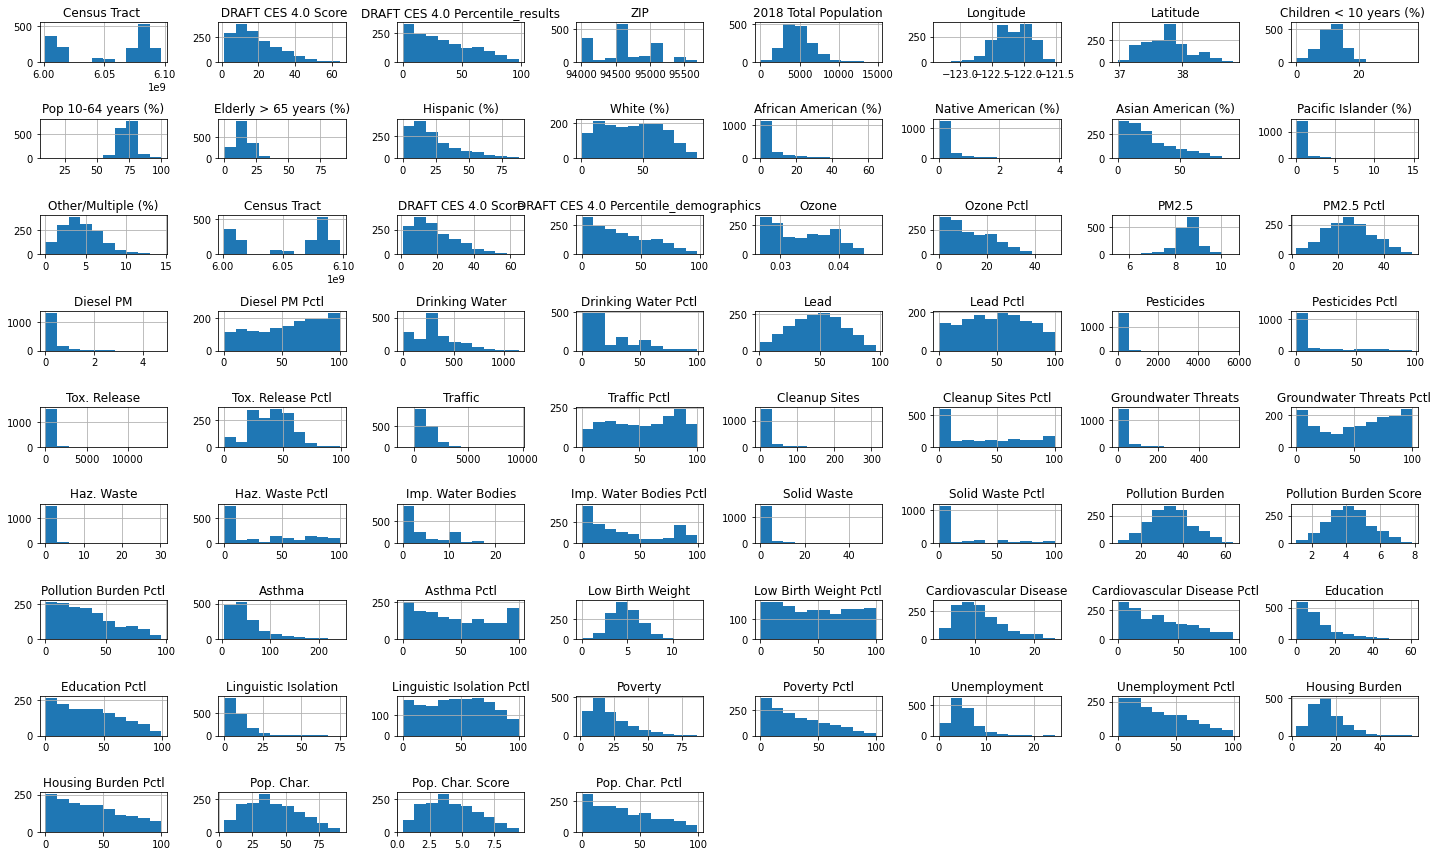

In [3]:
# plot histograms for each variable in the data set 
df1.hist(bins=10, figsize=(20, 12))
plt.tight_layout() # makes it so graphs aren't overlapping each other
plt.show()

Percentile histograms which don't appear uniform are confusing ... likely because this is a subset of the total CA dataset, so bay area percentiles may be skewed

But the non-normal distributions (even for the percentile metrics) indicate spearman correlation should be used.

## Plot matrix to vizualize pair-wise correlations between variables

All variables can't easily be visualized in a single scatter matrix, so pare down the dataset so the matrix is easier to load and view. Include only columns with raw data and the overall CES 4.0 Score.


In [4]:
# Exclude all the percentile columns
df_raw = df1[df1.columns.drop(list(df1.filter(regex='Pctl')))]

# Also exclude a few duplicate "Percentile" or "Score" columns which are derived not raw data 
df_raw = df_raw[df_raw.columns.drop(['Census Tract ','ZIP','Census Tract','DRAFT CES 4.0 Percentile_results','DRAFT CES 4.0 \nPercentile Range','DRAFT CES 4.0\nPercentile Range','DRAFT CES 4.0 Score','DRAFT CES 4.0 Percentile_demographics','Pollution Burden Score','Pop. Char. Score'])] 
df_raw.head()


DRAFT CES 4.0 Score  2018 Total Population   Longitude   Latitude  \
0             64.580115                   2440 -122.210924  37.762179   
1             63.194836                   7054 -122.196942  37.758804   
2             62.666135                   3904 -122.221368  37.720011   
3             61.811844                   3595 -122.244902  38.090042   
4             59.772651                   2327 -122.183500  37.732326   

  Nearby City \n(to help approximate location only) California County  \
0                                           Oakland          Alameda    
1                                           Oakland          Alameda    
2                                           Oakland          Alameda    
3                                           Vallejo           Solano    
4                                           Oakland          Alameda    

   Children < 10 years (%)   Pop 10-64 years (%)  Elderly > 65 years (%)  \
0                  7.377049             86.31148                6.311475   
1                 21.136940             69.79019                9.072866   
2                 16.086070             77.92008                5.993852   
3                 17.385260             69.06815               13.546590   
4                 13.321870             77.26687                9.411259   

   Hispanic (%)  ...  Pollution Burden  Asthma  Low Birth Weight  \
0      58.40164  ...         60.245371  113.30              7.35   
1      52.79274  ...         54.545633  194.40              8.95   
2      52.74078  ...         59.870285  173.63              8.29   
3      38.13630  ...         58.387518  199.35              6.42   
4      55.09239  ...         53.733100  226.34              6.77   

   Cardiovascular Disease  Education  Linguistic Isolation  Poverty  \
0                   12.41       38.6                  19.6     56.9   
1                   21.04       44.6                  11.9     66.6   
2                   15.26       32.8                  18.4     41.6   
3                   21.22       21.5                  12.8     42.7   
4                   19.11       31.8                   NaN     41.4   

   Unemployment  Housing Burden  Pop. Char.   
0          12.8            31.5    83.997258  
1          10.9            28.2    90.784474  
2           8.0            23.9    82.018449  
3          10.9            25.7    82.954826  
4          11.5            38.4    87.166698  

[5 rows x 39 columns]

### Make a correlation matrix (data table showing correlation statistic for each pair of variables)

In [5]:
# Set pandas to display all rows and columns so we can scroll through the matrix
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Color the table according to value of the correlation in order to find interesting correlations visually

In [6]:
# assign seaborn color palette
cm1 = sns.color_palette("viridis", as_cmap=True)

# run correlation matrix
cor_raw = df_raw.corr(method ='spearman')

# Display colored dataframe, adding vmin and vmax to show range of color appropriately to range of correlations
# Also set the observation axis to 'sticky' for easier scrolling
cor_raw_styled_matrix = cor_raw.style.background_gradient(cmap=cm1, vmin=-1, vmax=1).set_sticky(axis=0).set_sticky(axis=1)
cor_raw_styled_matrix

Could be helpful to also add p-values to this matrix to see which correlations may be meaningful.
Code adapted from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance/49040342 and https://enterprise-docs.anaconda.com/en/latest/data-science-workflows/data/stats.html)

In [8]:
# define a function to calculate p-values for correlations 
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 20)
    return pvalues

In [9]:
# define a function to calculate and return the correlation matrix
def correlation_matrix(df,columns):
    rho = df[columns].corr()
    pval = calculate_pvalues(df[columns])
    # create three masks
    r0 = rho.applymap(lambda x: '{:.2f}'.format(x))
    r1 = rho.applymap(lambda x: '{:.2f}*'.format(x))
    r2 = rho.applymap(lambda x: '{:.2f}**'.format(x))
    r3 = rho.applymap(lambda x: '{:.2f}***'.format(x))
    # apply marks
    rho = rho.mask(pval>0.01,r1)
    rho = rho.mask(pval<=0.01,r2)
    rho = rho.mask(pval<=0.001,r3)
    rho = rho.mask(pval<=0.0001,r4)
    return rho

In [10]:
# calculate spearman correlation p values
df_pvalues = calculate_pvalues(df_raw)

In [11]:
# see how many correlations comparisons were made to get estimate for crude multiple comparisons correction
df_pvalues.shape

# 37x37 so correction:

pvalue_mult_comp_correction = 0.05/(37*37)
pvalue_mult_comp_correction


3.6523009495982474e-05

In [12]:
# define a dataframe with values lower than the corrected p value, higher cells are NaN
df_low_pvalues = df_pvalues[df_pvalues < pvalue_mult_comp_correction]

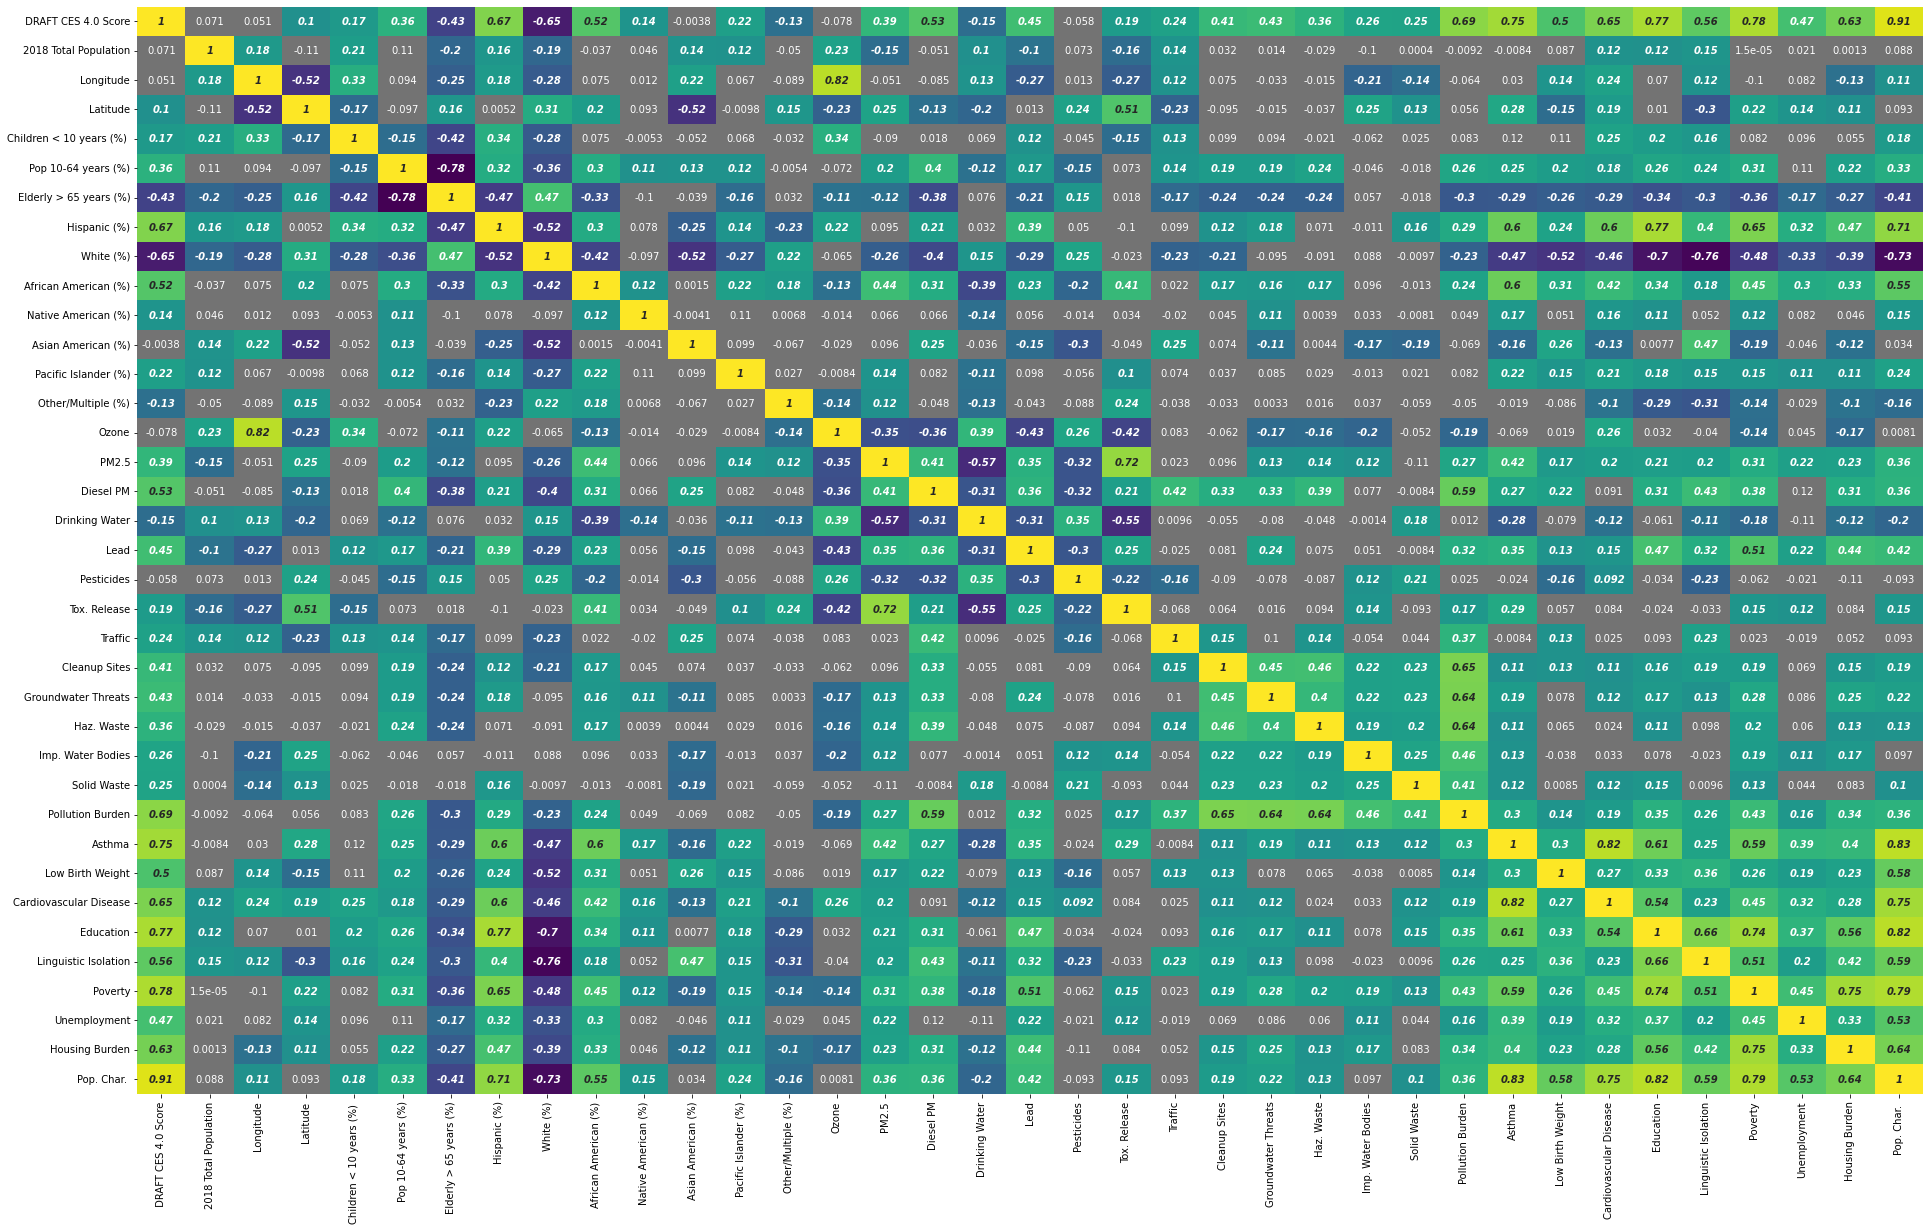

In [14]:
# Use seaborn heatmap and mask to plot the values from the correlation matrix only when 
# the corresponding pvalues are lower than the cutoff pvalue

p1 = plt.figure(figsize = (32,20))

# plot the correlation values with non-significant p values in grey
sns.heatmap(cor_raw, annot = True, 
            mask=df_pvalues == df_low_pvalues,
            cmap=ListedColormap(["0.45"]), #grey scale value from 0-1
            cbar=False)

# combine with pvalue-masked heatmap of correlation values
sns.heatmap(cor_raw, annot = True, 
            mask=df_pvalues != df_low_pvalues,
            annot_kws={"style": "italic", "weight": "bold"},
            cmap = cm1,
            cbar=False)

plt.savefig('20211122_correlation_matrix_pvalues.png')



A few interesting things I see to look into:
* Ozone varying with longitude 
* The clear racial differences along many variables, especially the risk factors
* Places with higher hispanic population having more lead exposure
* Places with higher AfAm population having higher PM2.5 exposure
* Correlations between PM2.5, Diesel PM, Lead, Tox. Release, Groundwater threats, Imp. water bodies, etc.
* Correlation between lead exposure and education, poverty, housing burden
* Pesticides, drinking water, and ozone exposures seem to correlate with each other, but inversely correlated with PM2.5, Diesel PM, Lead, Tox. Release (rural vs urban? cooler coastal vs hotter inland climates for ozone?)
* Correlations among variables
* Racial or age burden of overal pollution burden score

In [16]:
px.scatter(df1, x='Hispanic (%)', y="Lead", 
           color="DRAFT CES 4.0 Score", 
           trendline="ols",
           hover_name='Census Tract',
           hover_data=['Nearby City \n(to help approximate location only)', 'California County'],
           width=800, height=500)

# Radar plots (for group figure) 
Exposures for tracts with different percentages of racial/ethnic groups. Made using Plotly's graph objects,  which allows individual plotting of each line.

To see the correlation between exposures and race/ethnicity, examine tracts with over or under representation of specific groups. Subset the top 10% of tracts with e.g. highest Hispanic population.

### Preparing data and creating functions for plotting

In [19]:
# list of pollution variables of interest

col_pol_subset_pctl = [ 
    'Pollution Burden Pctl',
    'Lead Pctl',
    'Diesel PM Pctl',
    'Traffic Pctl',
    'Groundwater Threats Pctl',
    'Tox. Release Pctl',
    'Haz. Waste Pctl',
    'Drinking Water Pctl',
    'Pesticides Pctl',
    'Solid Waste Pctl',
]

In [20]:
# Write a function to automate the process of sorting by percent of a given race/ethnicity in the population
# Get mean exposure percentile for each of a set of variables for the top X percent for each race or ethnicity

def mean_values_top_X_percent(df, top_X_percent, column_label_to_sort, column_labels_to_average):
    df_sort = df.sort_values(column_label_to_sort, axis=0, ascending=False) # sort dataframe
    # get value of (100-X)th percentile
    value_of_100_minus_Xth_percentile = df_sort.iloc[round(df.shape[0]*(top_X_percent/100)),
                                            df.columns.get_loc(column_label_to_sort)]
    # add boolean column to original dataframe
    # True if the census tract is in top 20% by percent african american
    df["topX"] = df[[column_label_to_sort]] > value_of_100_minus_Xth_percentile
    # make data frame containing only top 20% rows and exposure columns, then get mean values
    data_a = df[(df["topX"]==True)] # grab relevant rows
    data_b = data_a.loc[:,column_labels_to_average] # grab subset of columns from a list of column names
    means_topX = data_b.mean(axis=0)
    
    df_means_topX = pd.DataFrame(columns=[column_label_to_sort], data = means_topX)
    
    return(df_means_topX)

# Test the function by creating a dataframe with mean percentile values for top 10% highest percent AA
mean_values_top_X_percent(df1,10,"African American (%)",col_pol_subset_pctl)

African American (%)
Pollution Burden Pctl                47.264421
Lead Pctl                            67.700018
Diesel PM Pctl                       69.686419
Traffic Pctl                         48.946361
Groundwater Threats Pctl             67.464297
Tox. Release Pctl                    53.904715
Haz. Waste Pctl                      41.078367
Drinking Water Pctl                  10.905866
Pesticides Pctl                       3.805402
Solid Waste Pctl                     17.969025

In [21]:
# Can convert function output to a list for better plotting
mean_values_top_X_percent(df1,10,"African American (%)",col_pol_subset_pctl)["African American (%)"].tolist()


[47.26442069112192,
 67.70001815336157,
 69.6864193835514,
 48.94636075949367,
 67.46429667164814,
 53.904714740384875,
 41.07836683812264,
 10.905865773231342,
 3.8054024155815904,
 17.969025289350284]

In [26]:
# define a similar function for bottom X percent

def mean_values_bottom_X_percent(df, bottom_X_percent, column_label_to_sort, column_labels_to_average):
    df_sort = df.sort_values(column_label_to_sort, axis=0, ascending= False) # sort dataframe
    # get value of (100-X)th percentile
    value_of_Xth_percentile = df_sort.iloc[round(df.shape[0]-(df.shape[0]*(bottom_X_percent/100))),
                                            df.columns.get_loc(column_label_to_sort)]
    # add boolean column to original dataframe
    # True if the census tract is in top 20% by percent african american
    df["bottomX"] = df[[column_label_to_sort]] < value_of_Xth_percentile
    # make data frame containing only top 20% rows and exposure columns, then get mean values
    data_a = df[(df["bottomX"]==True)] # grab relevant rows
    data_b = data_a.loc[:,column_labels_to_average] # grab subset of columns from a list of column names
    means_bottomX = data_b.mean(axis=0)
    
    df_means_bottomX = pd.DataFrame(columns=[column_label_to_sort], data = means_bottomX)
    
    return(df_means_bottomX)

In [27]:
# create a few empty columnn so I can plot a categorical axis/wedge of radar plot without any data
df1["Overall Pollution Burden"] = np.nan
df1["empty"] = np.nan

### Plotting

In [28]:
# Plotting mean of top 10% census tracts per race for exposure variables

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,"Hispanic (%)",col_pol_subset_pctl)["Hispanic (%)"].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% Hispanic (%)',
    mode = "lines",
    line = dict(color='#E58606')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'African American (%)',col_pol_subset_pctl)['African American (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% African American (%)',
    mode = "lines",
    line = dict(color='#5D69B1')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'Pacific Islander (%)',col_pol_subset_pctl)['Pacific Islander (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% Pacific Islander (%)',
    mode = "lines",
    line = dict(color='#52BCA3')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'Native American (%)',col_pol_subset_pctl)['Native American (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% Native American (%)',
    mode = "lines",
    line = dict(color='#99C945')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'Asian American (%)',col_pol_subset_pctl)['Asian American (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% Asian American (%)',
    mode = "lines",
    line = dict(color='#CC61B0')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'White (%)',col_pol_subset_pctl)['White (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% White (%)',
    mode = "lines",
    line = dict(color='#24796C')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'Other/Multiple (%)',col_pol_subset_pctl)['Other/Multiple (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% Other/Multiple (%)',
    mode = "lines",
    line = dict(color='#DAA51B')
))

# add traces for individual points in Pollution Burden category


fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'African American (%)',["Pollution Burden Pctl"])['African American (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% African American (%)',
    mode = "markers",
    marker = dict(color='#5D69B1',symbol = "arrow-right" , size = 15)    
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,"Hispanic (%)",["Pollution Burden Pctl"])["Hispanic (%)"].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% Hispanic (%)',
     mode = "markers",
    marker = dict(color='#E58606',symbol = "arrow-right" , size = 15)
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'Pacific Islander (%)',["Pollution Burden Pctl"])['Pacific Islander (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% Pacific Islander (%)',
    mode = "markers",
    marker = dict(color='#52BCA3',symbol = "arrow-right", size = 15)
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'Native American (%)',["Pollution Burden Pctl"])['Native American (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% Native American (%)',
     mode = "markers",
    marker = dict(color='#99C945',symbol = "arrow-right" , size = 15)
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'Asian American (%)',["Pollution Burden Pctl"])['Asian American (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% Asian American (%)',
     mode = "markers",
   marker = dict(color='#CC61B0',symbol = "arrow-right" , size = 15)
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'White (%)',["Pollution Burden Pctl"])['White (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% White (%)',
     mode = "markers",
    marker = dict(color='#24796C',symbol = "arrow-right" , size = 15)
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_top_X_percent(df1,10,'Other/Multiple (%)',["Pollution Burden Pctl"])['Other/Multiple (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% Other/Multiple (%)',
     mode = "markers",
    marker = dict(color='#DAA51B',symbol = "arrow-right" , size = 15) 
))



fig.update_layout(
    template="plotly_white",
    margin={'l': 2, 'r': 2, 't': 2, 'b': 2},
    polar=dict(
        radialaxis=dict(
        range = [0,80],
        visible=True,
        showticklabels=False,
        showline=False,
        ticks=""),
        angularaxis = dict(categoryarray = ["Overall Pollution Burden",
                                            "empty",
                                            'Solid Waste Pctl',
                                            'Pesticides Pctl',
                                            'Drinking Water Pctl',
                                            'Haz. Waste Pctl',
                                             'Tox. Release Pctl',
                                             'Groundwater Threats Pctl',
                                            'Traffic Pctl',
                                            'Diesel PM Pctl',
                                            'Lead Pctl'
                                            
                                           ],
                           rotation = 90,
                           showticklabels = False # can toggle to see category labels
                          )
    ),
    showlegend=False # can toggle to see legend
)

fig.show()

# saving a static image using kaleido
fig.write_image('images/20211130_radar_top10%.pdf', width=500, height=500, scale = 1)


In [29]:
# Plotting mean of bottom 10% census tracts per race for exposure variables

col_pol_subset_pctl = ["empty",
    "Overall Pollution Burden",
                       'Solid Waste Pctl',
                       'Pesticides Pctl',
                       'Drinking Water Pctl',
                       'Haz. Waste Pctl',
                       'Tox. Release Pctl',
                       'Groundwater Threats Pctl',
                       'Traffic Pctl',
                       'Diesel PM Pctl',
                       'Lead Pctl'
                      ]

# plotting

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,"Hispanic (%)",col_pol_subset_pctl)["Hispanic (%)"].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% Hispanic (%)',
    mode = "lines",
    line = dict(color='#E58606')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'African American (%)',col_pol_subset_pctl)['African American (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% African American (%)',
    mode = "lines",
    line = dict(color='#5D69B1')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'Pacific Islander (%)',col_pol_subset_pctl)['Pacific Islander (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% Pacific Islander (%)',
    mode = "lines",
    line = dict(color='#52BCA3')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'Native American (%)',col_pol_subset_pctl)['Native American (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% Native American (%)',
    mode = "lines",
    line = dict(color='#99C945')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'Asian American (%)',col_pol_subset_pctl)['Asian American (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% Asian American (%)',
    mode = "lines",
    line = dict(color='#CC61B0')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'White (%)',col_pol_subset_pctl)['White (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% White (%)',
    mode = "lines",
    line = dict(color='#24796C')
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'Other/Multiple (%)',col_pol_subset_pctl)['Other/Multiple (%)'].tolist(),
      theta=col_pol_subset_pctl,
      name='Top 10% Other/Multiple (%)',
    mode = "lines",
    line = dict(color='#DAA51B')
))

# add traces for individual points in Pollution Burden category


fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'African American (%)',["Pollution Burden Pctl"])['African American (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% African American (%)',
    mode = "markers",
    marker = dict(color='#5D69B1',symbol = "arrow-right" , size = 15)    
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,"Hispanic (%)",["Pollution Burden Pctl"])["Hispanic (%)"].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% Hispanic (%)',
     mode = "markers",
    marker = dict(color='#E58606',symbol = "arrow-right" , size = 15)
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'Pacific Islander (%)',["Pollution Burden Pctl"])['Pacific Islander (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% Pacific Islander (%)',
    mode = "markers",
    marker = dict(color='#52BCA3',symbol = "arrow-right", size = 15)
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'Native American (%)',["Pollution Burden Pctl"])['Native American (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% Native American (%)',
     mode = "markers",
    marker = dict(color='#99C945',symbol = "arrow-right" , size = 15)
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'Asian American (%)',["Pollution Burden Pctl"])['Asian American (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% Asian American (%)',
     mode = "markers",
   marker = dict(color='#CC61B0',symbol = "arrow-right" , size = 15)
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'White (%)',["Pollution Burden Pctl"])['White (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% White (%)',
     mode = "markers",
    marker = dict(color='#24796C',symbol = "arrow-right" , size = 15)
))
fig.add_trace(go.Scatterpolar(
      r=mean_values_bottom_X_percent(df1,10,'Other/Multiple (%)',["Pollution Burden Pctl"])['Other/Multiple (%)'].tolist(),
      theta=["Overall Pollution Burden"],
      name='Top 10% Other/Multiple (%)',
     mode = "markers",
    marker = dict(color='#DAA51B',symbol = "arrow-right" , size = 15) 
))



fig.update_layout(
    template="plotly_white",
    margin={'l': 2, 'r': 2, 't': 2, 'b': 2},
    polar=dict(
        radialaxis=dict(
        range = [0,80],
        visible=True,
        showticklabels=False,
        showline=False,
        ticks=""),
        angularaxis = dict(categoryarray = ["Overall Pollution Burden",
                                            "empty",
                                            'Solid Waste Pctl',
                                            'Pesticides Pctl',
                                            'Drinking Water Pctl',
                                            'Haz. Waste Pctl',
                                             'Tox. Release Pctl',
                                             'Groundwater Threats Pctl',
                                            'Traffic Pctl',
                                            'Diesel PM Pctl',
                                            'Lead Pctl'
                                            
                                           ],
                           rotation = 90,
                           showticklabels = False # can toggle to see category labels
                          )
    ),
    showlegend=False # can toggle to see legend
)

fig.show()

# saving a static image using kaleido
fig.write_image('images/20211130_radar_bottom10%.pdf', width=500, height=500, scale = 1)

---------------

# Ternary Plots (for individual figure)

Want to have a set of small multiples -- each plot has axes for percent population of different races (start with African American, Hispanic, White, Asian American based on correlation matrix), and color represents the percentile of a given exposure (e.g. lead)

In [32]:
# The three plotted variables must sum to 1 or 100 (or some constant)
# So will plot two race categories and the third will be the remaining percent in that tract
# Requires making new columns with "all other races/ethnicities" that correspond to different race pairings


# make new column of percentage not African American and not Hispanic
df1["NotAfAmNotHisp"] = 100 - df1["African American (%)"] -  df1["Hispanic (%)"]

# make similarly grouped columns to plot against African American and White
df1["NotAfAmNotWhite"] = 100 - df1["African American (%)"] -  df1["White (%)"]

# or against White and Hispanic
df1["NotWhiteNotHisp"] = 100 - df1["White (%)"] -  df1["Hispanic (%)"]

# or against African American and Asian American
df1["NotAfAmNotAsianAm"] = 100 - df1["African American (%)"] -  df1["Asian American (%)"]

# or against White and Asian American
df1["NotWhiteNotAsianAm"] = 100 - df1["White (%)"] -  df1["Asian American (%)"]

# or against Hispanic and Asian American
df1["NotHispNotAsianAm"] = 100 - df1["Hispanic (%)"] -  df1["Asian American (%)"]

# or against African American and Pacific Islander
df1["NotAfAmNotPI"] = 100 - df1["African American (%)"] -  df1["Pacific Islander (%)"]

# or against African American and Other/Multiple
df1["NotAfAmNotOtherMult"] = 100 - df1["African American (%)"] -  df1["Other/Multiple (%)"]

# see new columns for sanity check
df1[["African American (%)","Hispanic (%)", "White (%)","NotAfAmNotHisp","NotAfAmNotWhite","NotWhiteNotHisp"]].head()

African American (%)  Hispanic (%)  White (%)  NotAfAmNotHisp  \
0              7.909836      58.40164  15.778690       33.688524   
1             33.980720      52.79274   5.089311       13.226540   
2             32.300200      52.74078   1.895492       14.959020   
3             18.692630      38.13630  18.720450       43.171070   
4             33.863340      55.09239   1.461109       11.044270   

   NotAfAmNotWhite  NotWhiteNotHisp  
0        76.311474        25.819670  
1        60.929969        42.117949  
2        65.804308        45.363728  
3        62.586920        43.143250  
4        64.675551        43.446501

In [34]:
# ternary plot of LEAD burden Hispanic and White
fig = px.scatter_ternary(df1, a="Hispanic (%)", b="White (%)", c="NotWhiteNotHisp", 
                         hover_name="Census Tract",
                         hover_data=['Nearby City \n(to help approximate location only)', 'California County', 'Asian American (%)'],
                         color="Lead",
                        opacity = 0.5,
                        width=800, height=600,
                        template="plotly_white",
                        color_continuous_scale= "Plasma")
fig.update_ternaries(sum=100, baxis_min=0, aaxis_min = 0, caxis_title_text= "All other categories (%)");
fig.show()

# saving a static image using kaleido
fig.write_image('images/20211129_ternary_lead_HispWhite.pdf')

In [35]:
# ternary plot of LEAD burden Hispanic and African American
fig = px.scatter_ternary(df1, a="Hispanic (%)", b="African American (%)", c="NotAfAmNotHisp", 
                         hover_name="Census Tract",
                         hover_data=['Nearby City \n(to help approximate location only)', 'California County'],
                         color="Lead",
                        opacity = 0.5,
                        width=800, height=600,
                        template="plotly_white")
fig.update_ternaries(sum=100, 
                     baxis_min = 0, 
                     aaxis_min = 0,
                     caxis_title_text= "All other categories (%)")
fig.update_layout(showlegend=False)

fig.show()

# saving a static image using kaleido
fig.write_image('images/20211129_ternary_lead_HispAfAm.pdf')

In [36]:
# ternary plot of LEAD burden Hispanic and Asian Am.
fig = px.scatter_ternary(df1, a="Hispanic (%)", b="Asian American (%)", c="NotHispNotAsianAm", 
                         hover_name="Census Tract",
                         hover_data=['Nearby City \n(to help approximate location only)', 'California County', 'Asian American (%)'],
                         color="Lead",
                        opacity = 0.5,
                        width=800, height=600,
                        template="plotly_white")
fig.update_ternaries(sum=100, baxis_min=0, aaxis_min = 0, caxis_title_text= "All other categories (%)");
fig.show()

# saving a static image using kaleido
fig.write_image('images/20211129_ternary_lead_HispAsianAm.pdf')

In [37]:
# ternary plot of LEAD burden African American and Asian American
fig = px.scatter_ternary(df1, a="Asian American (%)", b="African American (%)", c="NotAfAmNotAsianAm", 
                         hover_name="Census Tract",
                         hover_data=['Nearby City \n(to help approximate location only)', 'California County'],
                         color="Lead",
                        opacity = 0.5,
                        width=800, height=600,
                        template="plotly_white")
fig.update_ternaries(sum=100, 
                     baxis_min = 0, 
                     aaxis_min = 0,
                     caxis_title_text= "All other categories (%)")
fig.update_layout(showlegend=False)

fig.show()

# saving a static image using kaleido
fig.write_image('images/20211129_ternary_lead_AfAmAsianAm.pdf')

In [38]:
# ternary plot of LEAD burden White and Asian American
fig = px.scatter_ternary(df1, a="Asian American (%)", b="White (%)", c="NotWhiteNotAsianAm", 
                         hover_name="Census Tract",
                         hover_data=['Nearby City \n(to help approximate location only)', 'California County'],
                         color="Lead",
                        opacity = 0.5,
                        width=800, height=600,
                        template="plotly_white")
fig.update_ternaries(sum=100, 
                     baxis_min = 0, 
                     aaxis_min = 0,
                     caxis_title_text= "All other categories (%)")
fig.update_layout(showlegend=False)

fig.show()

# saving a static image using kaleido
fig.write_image('images/20211129_ternary_lead_WhiteAsianAm.pdf')